## distributions

In [2]:
# imports
# imports
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import ptitprince as pt
import itertools
import random
import seaborn as sns
import os
import sys
import json
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.I_VDT import I_VDT
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.feature_extract.to_viewing import to_viewing
from src.d03_processing.preprocess import preprocess_timepoints
from src.d03_processing.fixations.FixAlgos import *
from src.d00_utils.TaskObjects import *
from src.d04_wrangling.add_ppt_info import *
from src.d03_processing.FeatureWrapper import *

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.linalg import orthogonal_procrustes
from scipy.spatial.distance import cdist
from scipy.spatial import procrustes

In [3]:
# get all viewings and all trials

# all_viewings = fetch_viewings("all")
# print(all_viewings.shape)

all_trials = fetch_trials("all")
print(all_trials.shape)

all_trials_info = add_ppt_info(all_trials, add_cols=['group'], drop_cols=[])
all_trials_info['condition'] = all_trials_info['condition_id'].str.rsplit('_', n=1).str[-1]

all_trials_info['dwell_tablepp_ret'] = all_trials_info['dwell_table_ret'] + all_trials_info['dwell_pp_ret']
# all_trials_info = all_trials_info[all_trials_info.practice == False]
print(all_trials_info.shape)
# display(all_trials_info.head(2).style)

def get_obj_number(row):
    for i in range(1, 5): # Assuming we have obj1 to obj4
        if row[f'obj{i}_name'] == row['selected_object']:
            return f'obj{i}'
    return None

all_trials_info['selected_obj_number'] = all_trials_info.apply(get_obj_number, axis=1)

for col in all_trials_info.filter(like='obj2').columns:
    base = col.replace('obj2_', '') # removing the '2' in 'obj2' so that we can replace it later
    all_trials_info[f'selected_{base}'] = all_trials_info.apply(lambda row: row[col.replace('2', row['selected_obj_number'][-1])] if row['selected_obj_number'] is not None else np.nan, axis=1)
# display(all_trials_info[['object_shifted', 'selected_object', 'selected_obj_number', 'obj1_name', 'obj2_name', 'obj3_name', 'obj4_name', 'selected_dwell_ret', 'dwell_obj1_ret', 'dwell_obj2_ret']].head(20).style)

(4355, 278)
(4355, 281)


In [4]:



def multimatch_col_split(df):
    import json
    from json.decoder import JSONDecodeError
    new_cols = ['vector', 'direction', 'length', 'position', 'duration']
    new_cols = [f'mm_{i}' for i in new_cols]
    new_dict = {}
    for col in new_cols:
        new_dict[col] = []
    print(new_dict)
    df = df.reset_index(drop=True)

    for i in range(len(df)):
        try:
            mm_values = json.loads(df.multimatch[i])
        except (TypeError, JSONDecodeError) as e:
            mm_values = [None]*5
        if len(mm_values) < 5:
            mm_values = [None]*5
        for i, col in enumerate(new_cols):
            new_dict[col].append(mm_values[i])

    df[new_cols] = pd.DataFrame(new_dict)
    return df

# print(all_trials['multimatch'].head(5))
# print(all_trials['multimatch'].describe())
# print(all_trials.multimatch.value_counts())
# print(pd.notnull(all_trials['multimatch'][1]))
# all_trials = multimatch_col_split(all_trials)
all_trials_info = multimatch_col_split(all_trials_info)
# print(all_trials[['mm_vector', 'mm_direction', 'mm_length', 'mm_position', 'mm_duration']].head(5))

cols_to_log = ['dwell_table_enc', 'dwell_table_ret','dwell_tablepp_ret']
for col in cols_to_log:
    all_trials_info[f"{col}_log"] = np.log2(((all_trials_info[col])/7000) + 0.5)

all_trials_info['ht_x_grf'] = all_trials_info['ht_enc'] * all_trials_info['gini_refix_ret']
all_trials_info['ht_x_grf'] = all_trials_info['ht_x_grf'][all_trials_info['ht_x_grf'] > 0]

all_trials_info['dwell_notMoved_enc'] = all_trials_info['dwell_obj2_enc'] + all_trials_info['dwell_obj3_enc'] + all_trials_info['dwell_obj4_enc']
all_trials_info['dwell_notMoved_ret'] =  all_trials_info['dwell_obj2_ret'] + all_trials_info['dwell_obj3_ret'] + all_trials_info['dwell_obj4_ret']
all_trials_info['dwell_MOminusSOs_enc'] = all_trials_info['dwell_obj1_enc'] - all_trials_info['dwell_notMoved_enc']
all_trials_info['dwell_MOminusSOs_ret'] = all_trials_info['dwell_obj1_ret'] - all_trials_info['dwell_notMoved_ret']
all_trials_info['dwell_MOminusTable_ret'] = all_trials_info['dwell_obj1_ret'] - all_trials_info['dwell_table_ret']
all_trials_info['dwell_array_enc'] = all_trials_info['dwell_obj1_enc'] + all_trials_info['dwell_notMoved_enc']
all_trials_info['dwell_array_ret'] = all_trials_info['dwell_obj1_ret'] + all_trials_info['dwell_notMoved_ret']
all_trials_info['redwell_notMoved_enc'] = all_trials_info['redwell_obj2_enc'] + all_trials_info['redwell_obj3_enc'] + all_trials_info['redwell_obj4_enc']
all_trials_info['redwell_notMoved_ret'] =  all_trials_info['redwell_obj2_ret'] + all_trials_info['redwell_obj3_ret'] + all_trials_info['redwell_obj4_ret']


# dwell time as proportion
for col in all_trials_info.columns:
    if 'dwell' in col and 'total' not in col and 'gini' not in col and 'gauss' not in col:
        if 'ret' in col:
            all_trials_info[col] /= all_trials_info['dwell_total_ret']
        else:
            all_trials_info[col] /= all_trials_info['dwell_total_enc']

eps = 0.01
all_trials_info['dwell_MOtabletoSOs_ratio_ret'] = (all_trials_info['dwell_obj1_ret'] + all_trials_info['dwell_table_ret'] + eps) / (all_trials_info['dwell_notMoved_ret'] + eps)
all_trials_info['dwell_MOtabletoSOs_logratio_ret'] = np.log(all_trials_info['dwell_MOtabletoSOs_ratio_ret'])
all_trials_info['dwell_relevant_ratio_ret'] = (all_trials_info['dwell_obj1_ret'] + all_trials_info['dwell_table_ret'] + all_trials_info['dwell_pp_ret'] + eps) / (all_trials_info['dwell_notMoved_ret'] + all_trials_info['dwell_other_ret'] + eps)
all_trials_info['dwell_relevant_logratio_ret'] = np.log(all_trials_info['dwell_relevant_ratio_ret'])
all_trials_info['redwell_MOtabletoSOs_ratio_ret'] = (all_trials_info['redwell_obj1_ret'] + all_trials_info['redwell_table_ret'] + eps) / (all_trials_info['redwell_notMoved_ret'] + eps)
all_trials_info['redwell_MOtabletoSOs_logratio_ret'] = np.log(all_trials_info['redwell_MOtabletoSOs_ratio_ret'])

all_trials_info['dwell_tableMinusSelected_ret'] = all_trials_info['selected_dwell_ret'] - all_trials_info['dwell_table_ret']
all_trials_info['dwell_movedMinusSelected_ret'] = all_trials_info['dwell_obj1_ret'] - all_trials_info['selected_dwell_ret']
print(np.unique(all_trials_info.group))

{'mm_vector': [], 'mm_direction': [], 'mm_length': [], 'mm_position': [], 'mm_duration': []}
['MCI+' 'MCI-' 'MCIu' 'O' 'Y']


C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# log transform some columns 



['StayRotate' 'StayStay' 'TeleportRotate' 'TeleportStay' 'WalkRotate'
 'WalkStay']
['lev_ratio_xfix_s', 'mm_vector', 'd_kl', 'ht_s_diff', 'ht_diff', 'ht_enc', 'ht_s_enc', 'ht_ret', 'gini_refix_enc', 'gini_redwell_enc', 'gini_refix_ret', 'gini_redwell_ret', 'gini_fix_enc', 'gini_fix_ret']
#####################################################
lev_ratio_xfix_s
0.500000    285
0.571429    211
0.666667    202
0.600000    128
0.545455    126
           ... 
0.378378      1
0.235294      1
0.846154      1
0.800000      1
0.758621      1
Name: lev_ratio_xfix_s, Length: 136, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


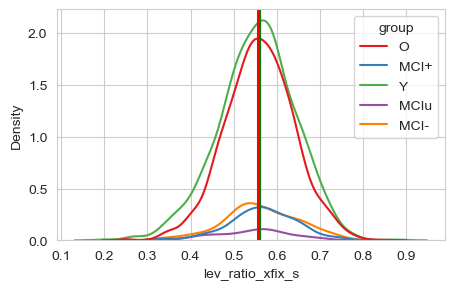

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

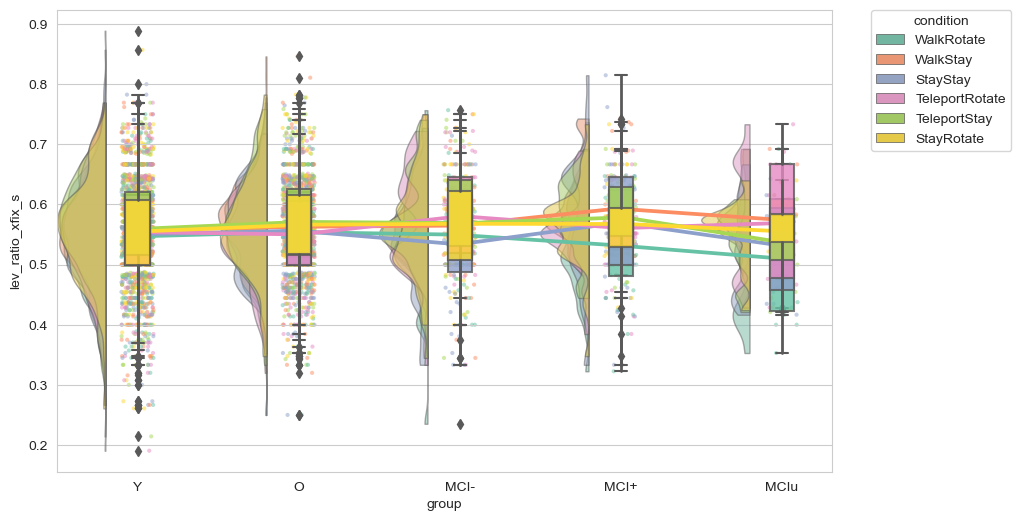

#####################################################
mm_vector
0.816242    1
0.669304    1
0.865330    1
0.824865    1
0.837581    1
           ..
0.708996    1
0.739659    1
0.811096    1
0.795286    1
0.865130    1
Name: mm_vector, Length: 4120, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


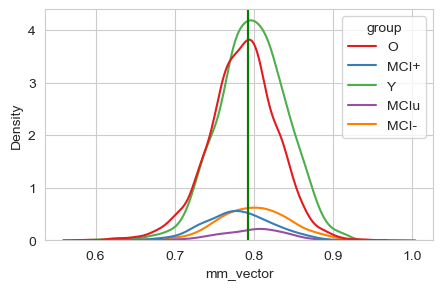

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

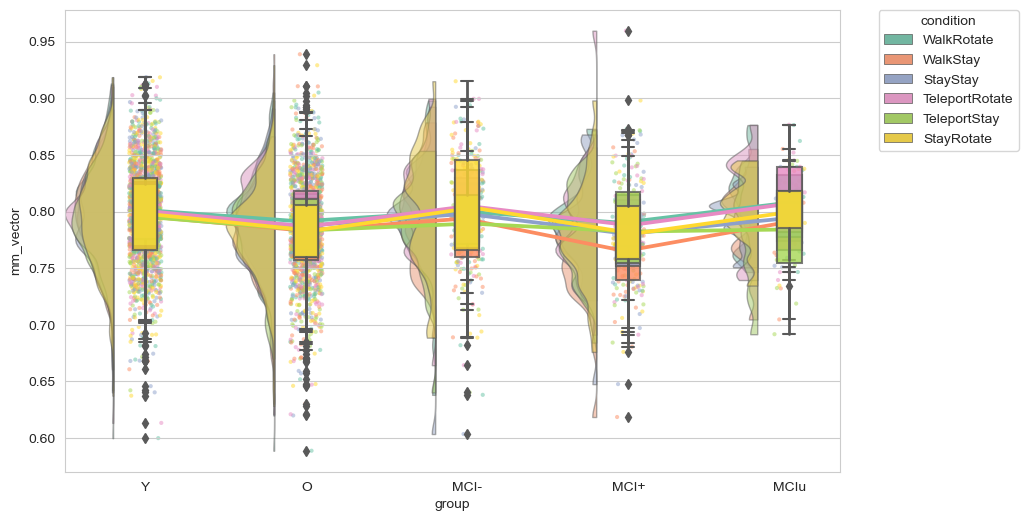

#####################################################
d_kl
8.411936     1
13.459390    1
13.406589    1
2.855578     1
14.394426    1
            ..
8.142912     1
14.304277    1
12.487288    1
4.661959     1
14.335380    1
Name: d_kl, Length: 4166, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


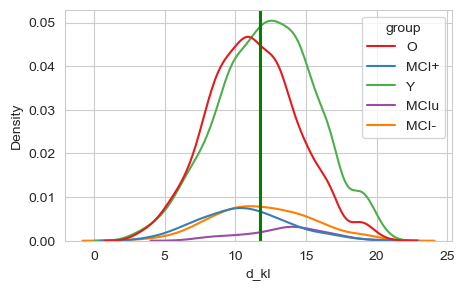

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

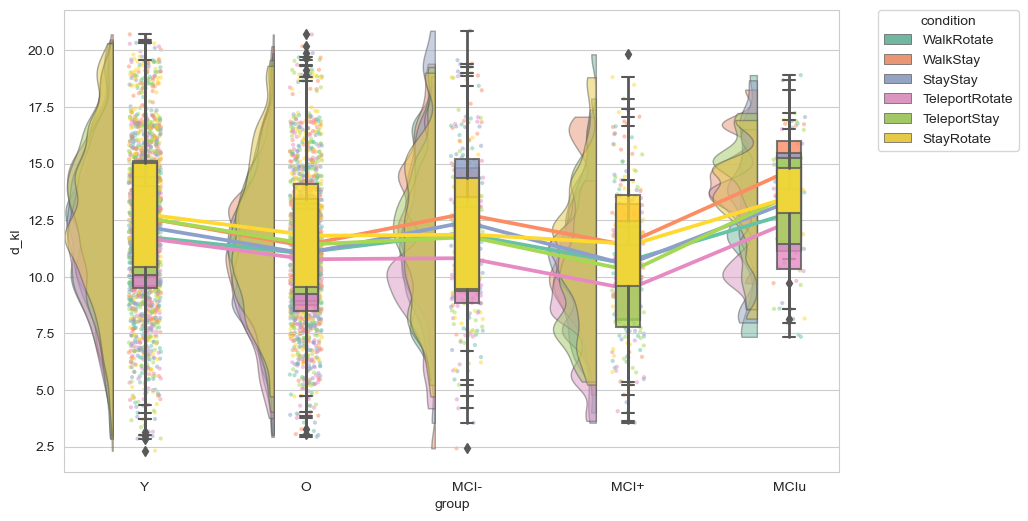

#####################################################
ht_s_diff
 0.000000e+00    19
-2.857143e-01     5
-1.110223e-16     4
-4.000000e-01     4
 2.500000e-01     4
                 ..
-2.979449e-01     1
 4.400456e-01     1
 9.878558e-03     1
-3.204101e-01     1
 1.615619e-01     1
Name: ht_s_diff, Length: 3880, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


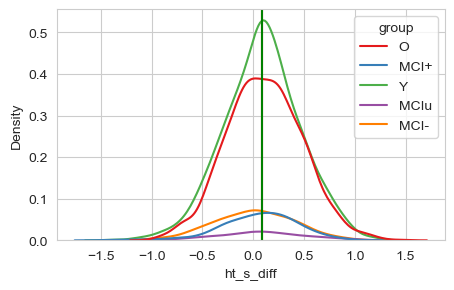

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

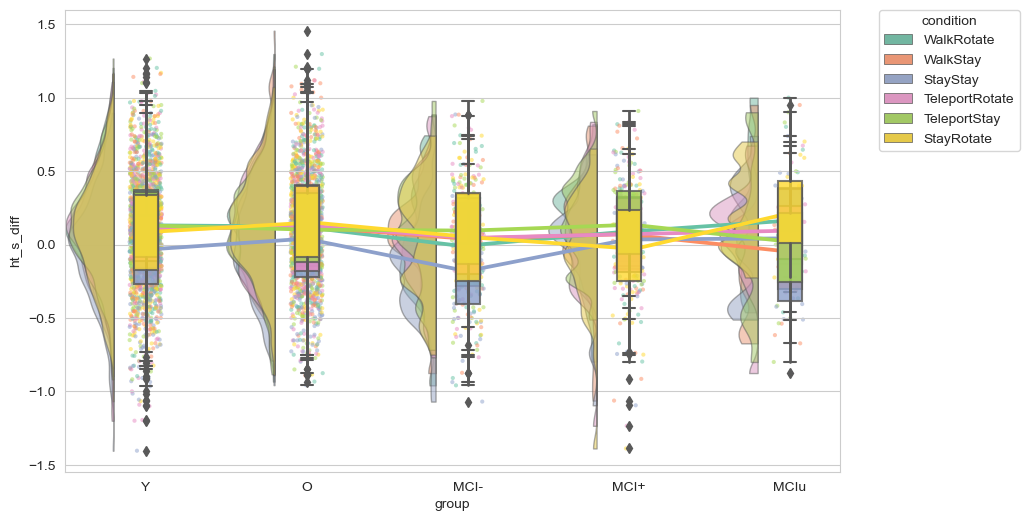

#####################################################
ht_diff
 0.000000e+00    20
 2.500000e-01     5
-1.110223e-16     5
 1.037594e-01     4
-5.000000e-01     4
                 ..
 2.263841e-01     1
 4.010712e-01     1
 5.505490e-01     1
 7.816410e-01     1
 1.615619e-01     1
Name: ht_diff, Length: 3893, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


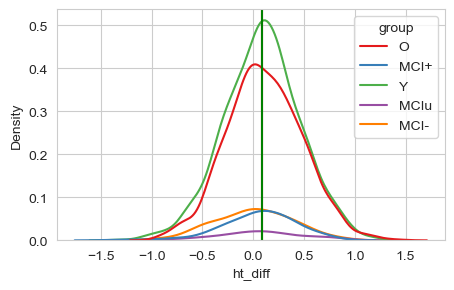

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

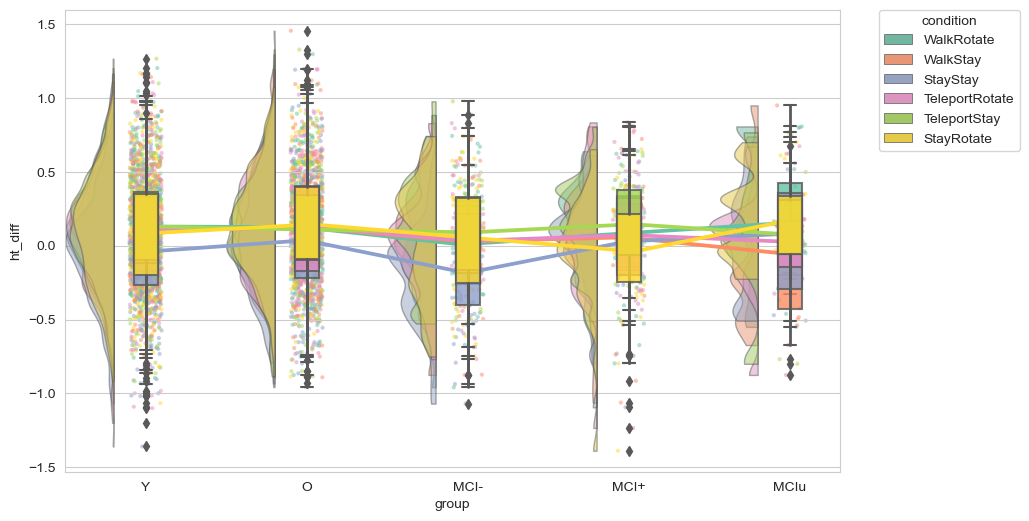

#####################################################
ht_enc
0.000000    100
0.666667     61
0.500000     59
0.528321     54
0.614081     54
           ... 
0.741388      1
0.875489      1
1.272783      1
0.714286      1
1.051272      1
Name: ht_enc, Length: 904, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


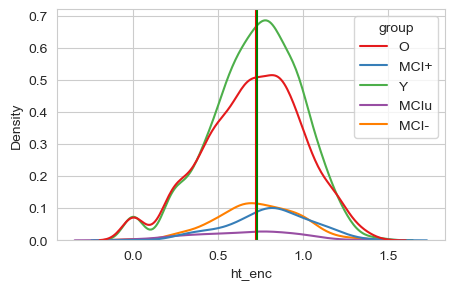

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

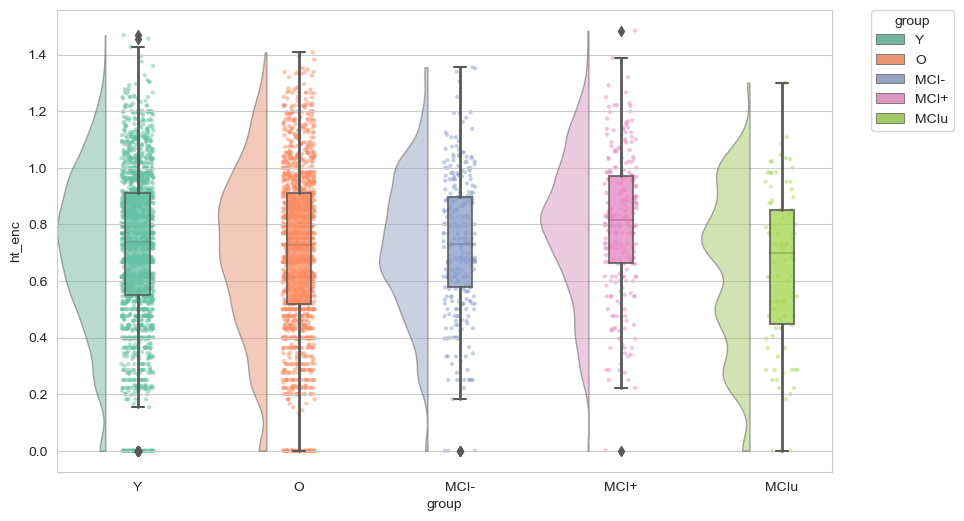

#####################################################
ht_s_enc
0.000000    88
0.500000    72
0.795899    54
0.528321    52
0.864525    46
            ..
1.088602     1
1.288959     1
1.224302     1
0.760964     1
0.981844     1
Name: ht_s_enc, Length: 1045, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


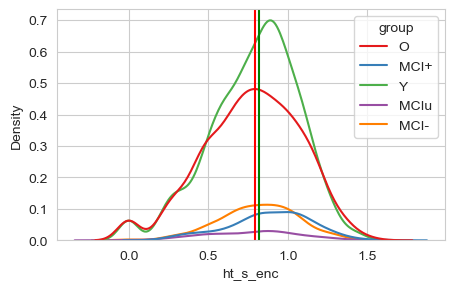

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

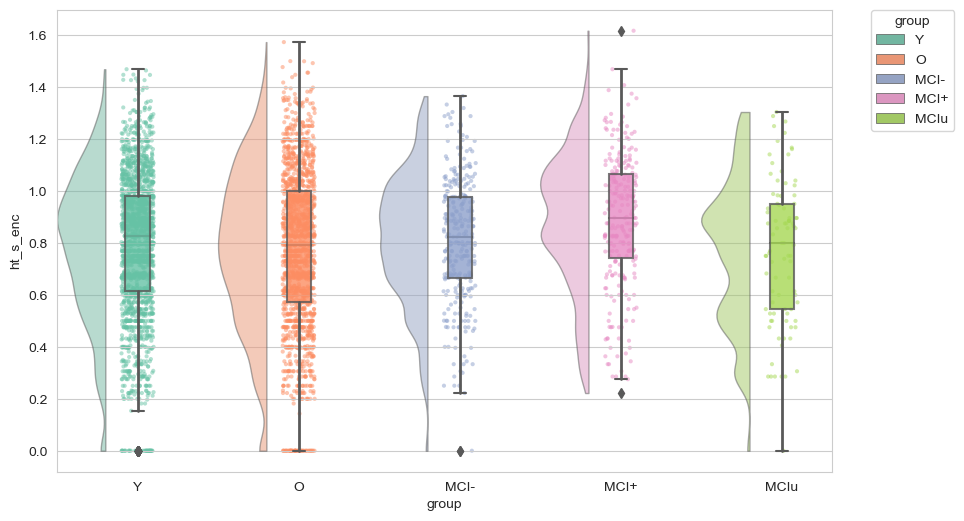

#####################################################
ht_ret
0.000000    110
0.528321     51
0.500000     46
0.675489     45
0.333333     44
           ... 
0.840617      1
0.614619      1
1.025800      1
1.202882      1
1.344361      1
Name: ht_ret, Length: 1133, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


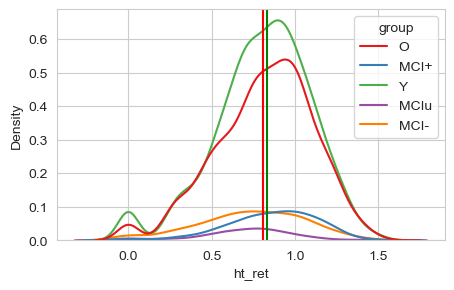

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

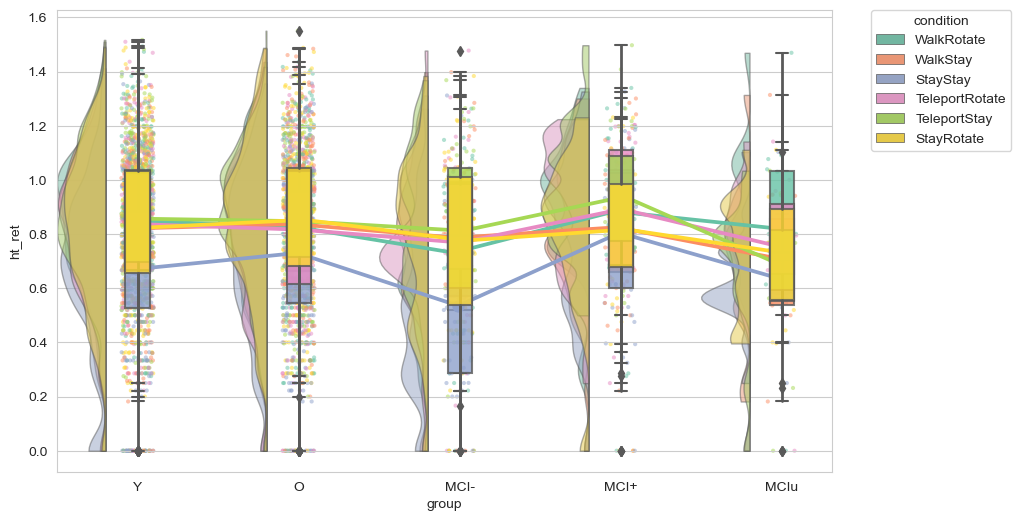

#####################################################
gini_refix_enc
0.727273    527
0.690909    234
0.772727    195
0.787879    167
0.696970    163
           ... 
0.454545      1
0.561983      1
0.618182      1
0.678788      1
0.673797      1
Name: gini_refix_enc, Length: 128, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


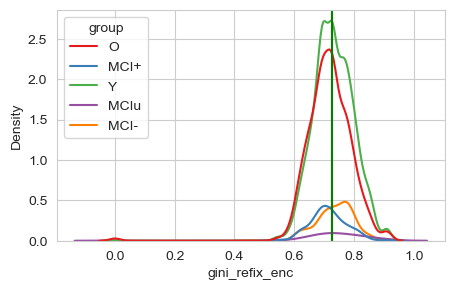

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

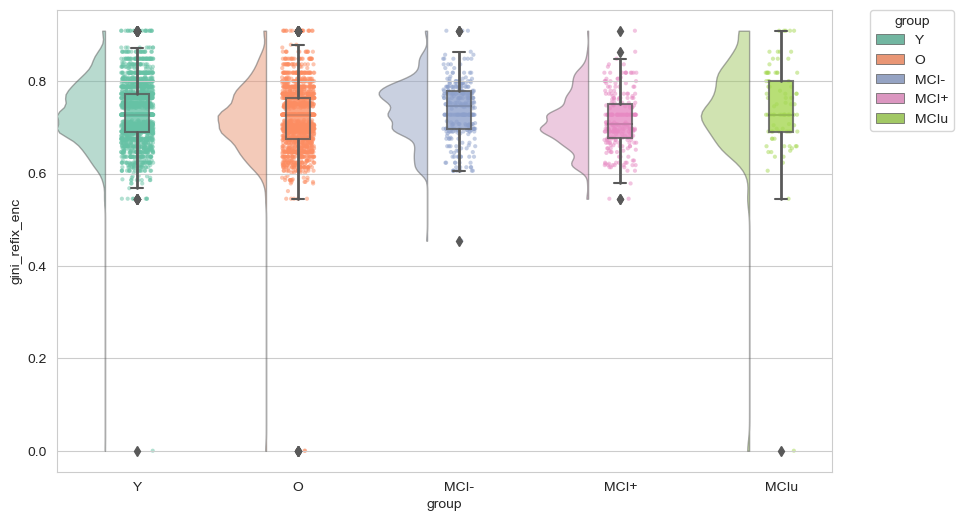

#####################################################
gini_redwell_enc
9.090909e-01    51
2.018587e-17     7
7.923939e-01     2
7.200000e-01     2
8.408890e-01     2
                ..
7.961378e-01     1
7.016185e-01     1
7.870623e-01     1
7.755816e-01     1
8.323672e-01     1
Name: gini_redwell_enc, Length: 4088, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


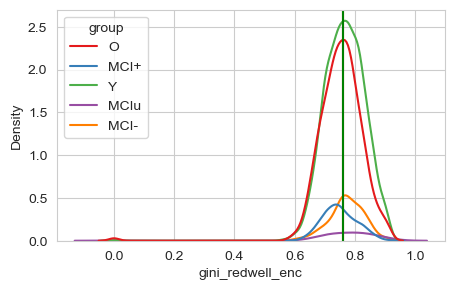

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

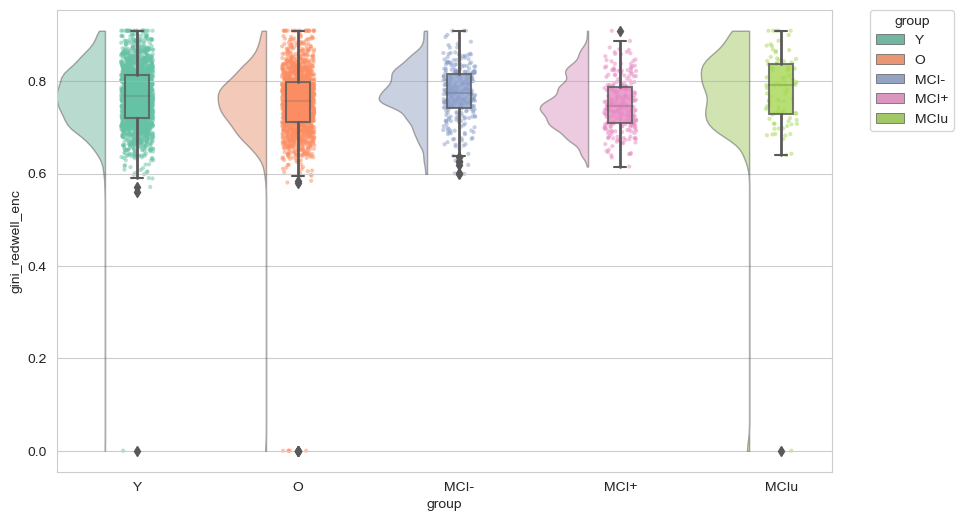

#####################################################
gini_refix_ret
0.727273    426
0.818182    218
0.772727    179
0.787879    152
0.690909    130
           ... 
0.602871      1
0.568182      1
0.571429      1
0.593939      1
0.703030      1
Name: gini_refix_ret, Length: 154, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


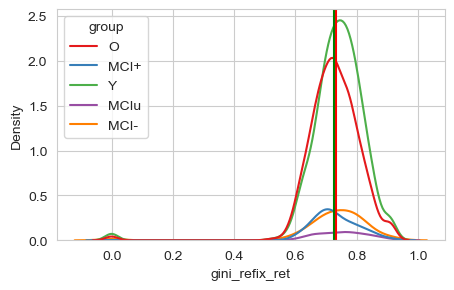

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

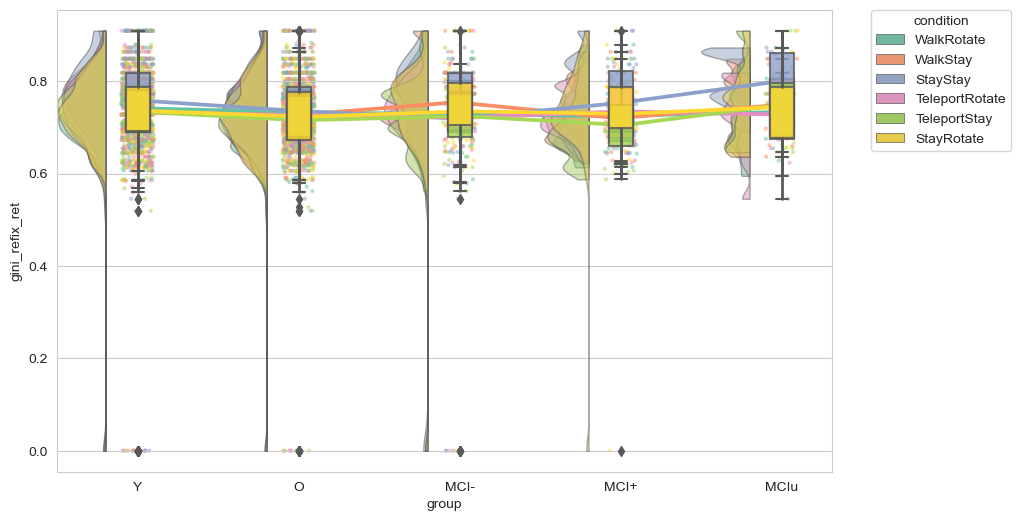

#####################################################
gini_redwell_ret
9.090909e-01    105
2.018587e-17     32
8.635412e-01      2
7.172253e-01      2
7.272727e-01      2
               ... 
8.391248e-01      1
7.789750e-01      1
8.911410e-01      1
8.379090e-01      1
8.203645e-01      1
Name: gini_redwell_ret, Length: 4016, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


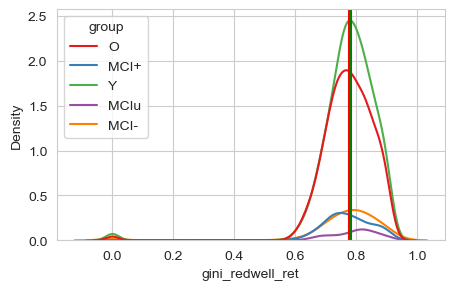

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

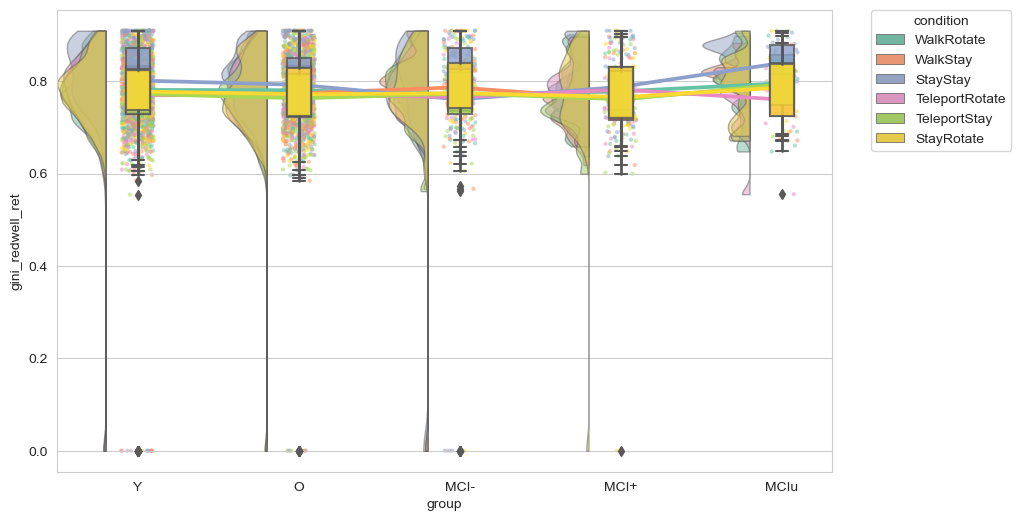

#####################################################
gini_fix_enc
0.545455    170
0.590909    130
0.636364    100
0.601399     99
0.575758     97
           ... 
0.537190      1
0.669856      1
0.679426      1
0.679426      1
0.454545      1
Name: gini_fix_enc, Length: 252, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


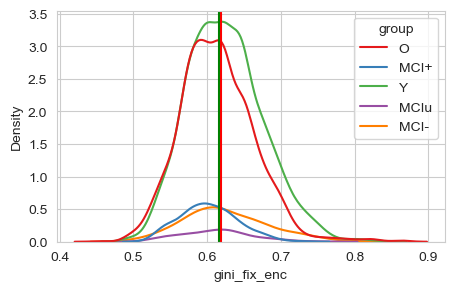

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

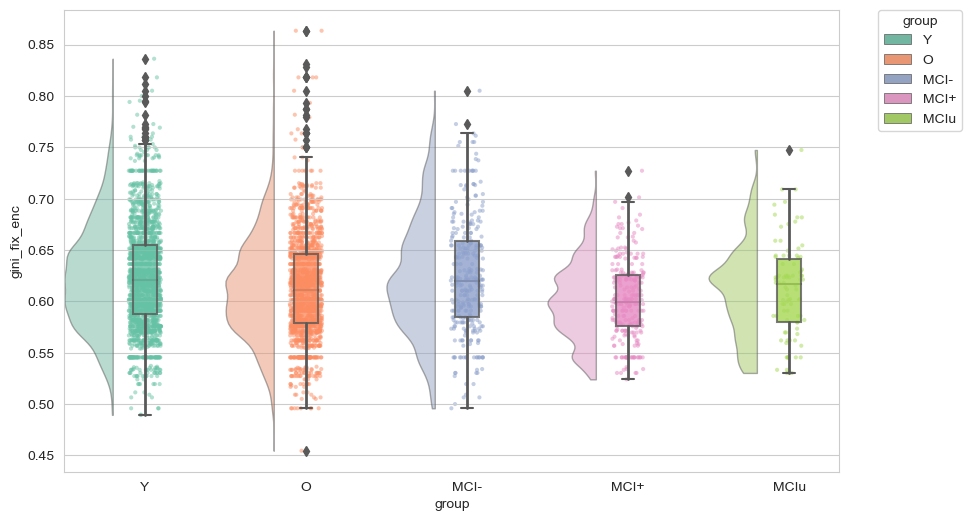

#####################################################
gini_fix_ret
0.636364    128
0.727273    128
0.545455     89
0.666667     86
0.590909     72
           ... 
0.676768      1
0.608696      1
0.775758      1
0.528139      1
0.787879      1
Name: gini_fix_ret, Length: 345, dtype: int64


C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


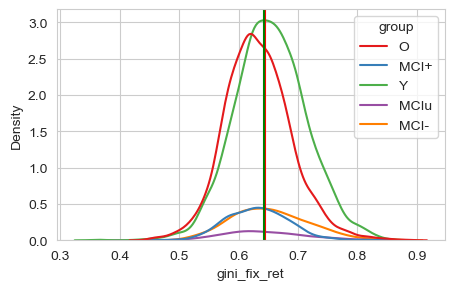

C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

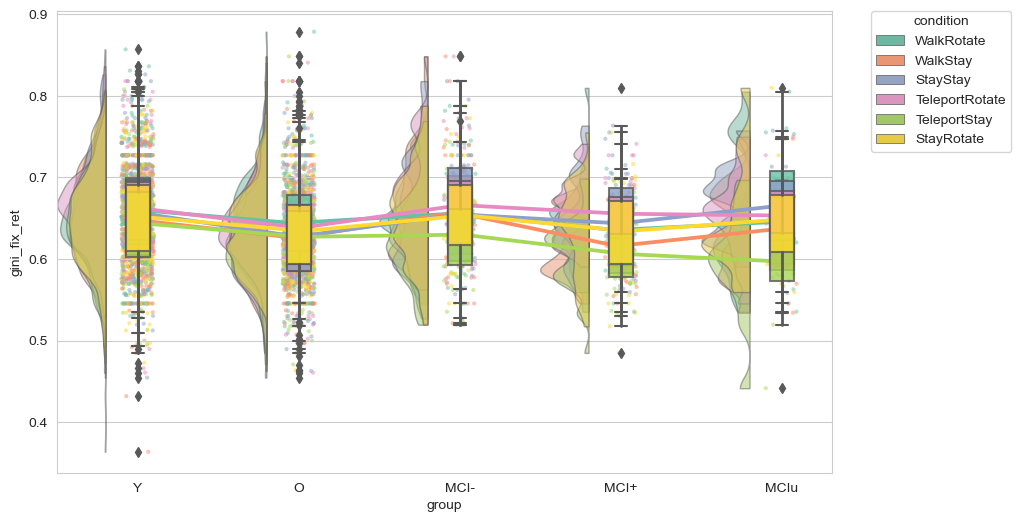

In [9]:
# display(all_viewings.describe.style())
# display(all_trials_info.head(10).style)
df = all_trials_info.copy()
conditions = ['StayStay', 'WalkStay'] #, 'TeleportStay', 'StayRotate'] #, 'TeleportRotate']
conditions = list(np.unique(df.condition.to_list()))
print(np.unique(df.condition))


# lower confidence only
# df = df[df.confidence_rating < 10]

plt.close('all')
columns = df.columns
columns = list(columns)[-15:]

columns = ['hn_enc', 'hn_ret', 'hd_enc', 'hd_ret', 'ht_enc', 'ht_ret', 'n_transitions_enc', 'n_transitions_ret', 'd_kl', 'ea_td']
# columns = ['n_fix_table_ret', 'dwell_table_ret', 'n_fix_obj1_ret', 'n_fix_obj2_ret', 'n_fix_obj1_diff', 'dwell_obj1_ret', 'dwell_obj2_ret', 'dwell_obj1_diff']
# columns = ['n_fix_obj1_ret', 'dwell_obj1_ret']
           # 'n_fix_total_enc', 'n_fix_total_ret', 'n_fix_obj1_ret', 'n_fix_obj1_enc', 'dwell_obj1_enc', 'dwell_obj1_ret', ]
columns = ['selected_dwell_diff', 'selected_dwell_ret', 'dwell_relevant_logratio_ret', 'redwell_MOtabletoSOs_logratio_ret', 'dwell_MOtabletoSOs_logratio_ret', 'gauss_dwell_centroid_ret', 'gauss_dwell_pp_ret', 'dwell_pp_ret', 'ht_s_enc', 'hd_s_enc',
           'dwell_table_ret', 'dwell_table_ret_log', 'mm_vector', 'd_kl', 'n_transitions_ret']
columns = ['gauss_dwell_centroid_ret', 'gauss_dwell_pp_ret', 'dwell_obj1_ret', 'dwell_notMoved_ret', 'dwell_table_ret']
# columns = ['dwell_obj1_enc_log', 'dwell_obj1_ret_log']
# columns = ['pupil_diam_centre_enc', 'pupil_diam_centre_ret']
# columns = df.filter(like='gini').columns.to_list()
columns = ['lev_ratio_xfix_s',  'mm_vector', 'd_kl', 'ht_s_diff', 'ht_diff', 'ht_enc', 'ht_s_enc', 'ht_ret', 'gini_refix_enc', 'gini_redwell_enc', 'gini_refix_ret', 'gini_redwell_ret', 'gini_fix_enc', 'gini_fix_ret']
# columns = [ 'ht_s_enc', 'ht_enc',  ]
# columns = ['dwell_MOtabletoSOs_ratio_ret', 'dwell_MOtabletoSOs_logratio_ret']
# columns = ['t_first_obj1_ret', 't_first_table_ret']
# columns = ['dwell_tablepp_ret_log', 'dwell_table_ret_log', 'dwell_table_ret', 'selected_dwell_ret',  'dwell_table_enc_log', 'n_fix_table_ret', 'n_fix_table_enc']
print(columns)
group_order = group_plot_order()
for column in columns:
    print('#####################################################')
    print(column)
    print(df[column].value_counts())
    x = df[column]
    df2 = df.copy(deep=True)
    if x.dtype == np.float_ or x.dtype == np.int_:
        x = x[x != FeatureWrapper.num_too_low]
        x = x[x != FeatureWrapper.num_too_high]
        df2 = df2[df2[column] != FeatureWrapper.num_too_low]
        df2 = df2[df2[column] != FeatureWrapper.num_too_high]
    if x.dtype == np.int_:
        x = x[x != FeatureWrapper.null_int]
        df2 = df2[df2[column] != FeatureWrapper.null_int]
    # if x.dtype == np.object_:
    #     x = x[x != FeatureWrapper.null_str]
    try:
        ax = plt.figure(figsize=(5,3)).add_subplot()
        sns.set_palette('Set1')
        sns.kdeplot(data=df2, x=column, hue='group')
        try:
            ax.axvline(np.nanmean(x),c='r')
            ax.axvline(np.nanmedian(x), c='g')
        except Exception as e:
            print(e)
    except Exception as e:
        print(e)
    finally:
        plt.show()
        
        
    try:
        # Initialize figure and ax
        f, ax = plt.subplots(figsize=(10, 6))

        if 'enc' in column:
            ax=pt.RainCloud(y=column, x='group', data=df2, palette="Set2", bw=.2,hue='group', hue_order=group_order,
                            width_viol=.6, ax=ax, orient='v', pointplot=False, alpha=.5, order=group_order, rain_alpha=0.5)
        else:
            df2 = df2[df2.condition.isin(conditions)]
            if len(conditions) > 1:
                # Create the raincloud plot
                dodge_bool = len(conditions) < 6
                ax=pt.RainCloud(y=column, x='group',hue='condition', data=df2, palette="Set2", bw=.2,
                             width_viol=.6, ax=ax, orient='v', pointplot=True, alpha=.5, order=group_order, dodge=dodge_bool, rain_alpha=0.5)
                # ax.legend(loc='upper center')
            else:

                ax=pt.RainCloud(y=column, x='group',data=df2, hue='group', hue_order=group_order, palette="Set2", bw=.2,
                             width_viol=.6, ax=ax, orient='v', pointplot=False, alpha=.5,  order=group_order, rain_alpha=0.5)

    except Exception as e:
        print(e)
    finally:
        plt.show()